In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras as K
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np


tf.keras.backend.set_floatx("float64")

In [2]:
def import_data(dataset):
    if dataset == "pets":
        ds,info = tfds.load('oxford_iiit_pet', split='all',with_info=True)
    else:
        ds,info = tfds.load('caltech_birds2010', split='all',with_info=True)
    ds_train = ds.skip(300)
    ds_test = ds.take(300)
    return ds_train,ds_test,info
dataset = "birds"
ds_train_raw,ds_test_raw,info = import_data(dataset)

In [3]:
IMAGE_SIZE = 128
def pre_process_image(record):
    
    image = record["image"]
    image = image / 255
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float64)
    
    seg_image = record["segmentation_mask"]
    seg_image = tf.image.resize(seg_image, (IMAGE_SIZE, IMAGE_SIZE))

    seg_image = tf.cast(seg_image, tf.uint8)
    seg_image = seg_image % 2
    seg_image = tf.cast(seg_image, tf.float64)
    return image,seg_image

resize_train = ds_train_raw.map(pre_process_image)
resize_test = ds_test_raw.map(pre_process_image)

In [4]:

def dice_coef(y_true, y_pred):
    y_true_f = K.backend.flatten(y_true)
    y_pred_f = K.backend.flatten(y_pred)
    intersection = K.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.backend.sum(y_true_f) + K.backend.sum(y_pred_f))

def diceCoefLoss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

In [5]:
input_img = Input(next(iter(resize_train))[0].shape, name="input_img") 
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(2, padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same',name="decoded")(x)
    
autoencoder = K.Model(input_img, decoded)
optimizer = K.optimizers.rmsprop_v2.RMSprop(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss=diceCoefLoss,metrics=[K.metrics.MeanIoU(num_classes=2),dice_coef])

In [6]:
callbacks = [
    K.callbacks.ModelCheckpoint(f"{dataset}_autoencoder.h5", save_best_only=True, monitor="val_dice_coef",mode="max")
]

# Train the model, doing validation at the end of each epoch.
epochs = 80


In [7]:
ds_train = resize_train.batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = resize_test.batch(64).prefetch(tf.data.AUTOTUNE)

In [8]:
history = autoencoder.fit(ds_train,validation_data=ds_test,epochs=epochs,verbose=2,callbacks=callbacks)

Epoch 1/80
90/90 - 707s - loss: 0.5286 - mean_io_u: 0.4193 - dice_coef: 0.4718 - val_loss: 0.4247 - val_mean_io_u: 0.4187 - val_dice_coef: 0.5780 - 707s/epoch - 8s/step
Epoch 2/80
90/90 - 417s - loss: 0.4258 - mean_io_u: 0.4193 - dice_coef: 0.5742 - val_loss: 0.4087 - val_mean_io_u: 0.4187 - val_dice_coef: 0.5943 - 417s/epoch - 5s/step
Epoch 3/80
90/90 - 417s - loss: 0.4068 - mean_io_u: 0.4193 - dice_coef: 0.5931 - val_loss: 0.3927 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6101 - 417s/epoch - 5s/step
Epoch 4/80
90/90 - 419s - loss: 0.3876 - mean_io_u: 0.4193 - dice_coef: 0.6124 - val_loss: 0.3781 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6244 - 419s/epoch - 5s/step
Epoch 5/80
90/90 - 399s - loss: 0.3726 - mean_io_u: 0.4193 - dice_coef: 0.6273 - val_loss: 0.3676 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6347 - 399s/epoch - 4s/step
Epoch 6/80
90/90 - 404s - loss: 0.3620 - mean_io_u: 0.4193 - dice_coef: 0.6379 - val_loss: 0.3605 - val_mean_io_u: 0.4187 - val_dice_coef: 0.6417 - 404s/ep

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_dice_coef"],label= "val_dice_coef")
plt.plot(history.history["dice_coef"],label="train_dice_coef")
plt.legend()

In [10]:
autoencoder.load_weights(f"{dataset}_autoencoder.h5")

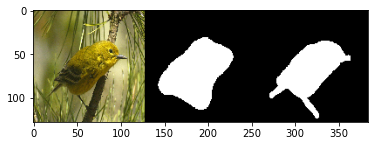

tf.Tensor(0.8401862940785096, shape=(), dtype=float64)


In [11]:
image = next(iter(resize_train.shuffle(100).take(1)))

mask = np.repeat(image[1],3).reshape(IMAGE_SIZE,IMAGE_SIZE,3)
pred = np.round(np.repeat(autoencoder.predict(image[0].numpy().reshape(-1,128,128,3))[0],3).reshape((IMAGE_SIZE,IMAGE_SIZE,3)))
plt.imshow(np.hstack([image[0],pred,mask]))

# display that image
plt.show()
print(dice_coef(mask,pred))

In [12]:


for split in ["train","test"]:
    
    if split == "train":
        ds = resize_train
    else:
        ds = resize_test
    dice_coeff_vals = []
    n = int(ds.cardinality())
    for image in iter(ds):

        mask = image[1]
        pred = autoencoder.predict(tf.reshape(image[0],(-1,128,128,3)))
        dice_coeff_vals.append(dice_coef(mask,pred[0]))

    dice_coeff_mean = sum(dice_coeff_vals)/n
    dice_coeff_std = (sum([((x - dice_coeff_mean) ** 2) for x in dice_coeff_vals]) / n)**0.5
    np.save(f"CNN_{dataset}_{split}",dice_coeff_vals)